In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install catboost
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
#!pip install prophet

In [3]:
from prophet import Prophet

In [4]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\\Users\\user\\Desktop\\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.0,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.0,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.0,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.0,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.0,6743


In [5]:
# 불필요한 컬럼들 제거
# Unnamed: 단순 데이터 순서를 나타내는 컬럼이기에 삭제
# O_YMD: 주문 시간은 오더 건수와 큰 상관이 없기에 삭제
# ORD_NO: 주문 내용의 일련번호이기에 삭제
# PKG_GOODS_NO: PKG_GOODS_NM과 내용이 겹치고 잘못 적재된 데이터이기에 삭제
# RECVR_ROAD_BASE_ADDR: 비대면으로 주문하는 시대에 지역정보는 큰 의미가 없을 것 같아 삭제
# 등등 미래에 예측할 수 없는 데이터는 모두 삭제

# 카피 데이터 생성
# copy_data = raw_data[['H_YMD', 'O_YMD', 'GOODS_NO', 'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'REAL_ORD_QTY']]
copy_data = raw_data[['H_YMD', 'GOODS_NO','REAL_ORD_QTY']]

# 희망배송일 순서대로 데이터를 정렬
copy_data = copy_data.sort_values(by = 'H_YMD')

copy_data

,H_YMD,GOODS_NO,REAL_ORD_QTY
166288,2020-01-01 00:00:00,14375,1
37753,2020-01-01 00:00:00,1901012353,2
162585,2020-01-01 00:00:00,1823,1
164041,2020-01-01 00:00:00,1712010310,1
164040,2020-01-01 00:00:00,1712010310,1
...,...,...,...
236658,2022-05-31 00:00:00,1803010879,1
241774,2022-05-31 00:00:00,1909013359,1
236656,2022-05-31 00:00:00,1803010879,1
241810,2022-05-31 00:00:00,1909013359,1


In [6]:
copy_data = copy_data.groupby(['H_YMD', 'GOODS_NO'], as_index=False)
copy_data = copy_data.agg({
                           'REAL_ORD_QTY':['sum', 'mean']
                        })

copy_data.columns = ['H_YMD', 'GOODS_NO',
                     'REAL_ORD_QTY', 'mean_real_ord_qty',]

copy_data.drop(['mean_real_ord_qty'], axis=1, inplace=True)

copy_data.columns = ['ds', 'GOODS_NO', 'y']

copy_data[copy_data['GOODS_NO']=="1823"]

,ds,GOODS_NO,y


In [7]:
copy_data['ds'] = pd.to_datetime(copy_data['ds'])

In [8]:
idx = copy_data[(copy_data['ds'].dt.year == 2022) & (copy_data['ds'].dt.month == 5) & (copy_data['ds'].dt.day > 24)].index
train_data = copy_data.drop(idx)
test_data = copy_data[(copy_data['ds'].dt.year == 2022) & (copy_data['ds'].dt.month == 5) & (copy_data['ds'].dt.day > 24)]

In [17]:
train_data[train_data['GOODS_NO']==14375]

,ds,GOODS_NO,y
4,2020-01-01,14375,97
16,2020-01-02,14375,115
28,2020-01-03,14375,200
40,2020-01-04,14375,164
52,2020-01-06,14375,112
...,...,...,...
10715,2022-05-19,14375,99
10735,2022-05-20,14375,133
10755,2022-05-21,14375,193
10775,2022-05-23,14375,131


In [26]:
train_data[train_data['GOODS_NO']==1712010310]

,ds,GOODS_NO,y
6,2020-01-01,1712010310,86
18,2020-01-02,1712010310,167
30,2020-01-03,1712010310,156
42,2020-01-04,1712010310,175
54,2020-01-06,1712010310,174
...,...,...,...
10717,2022-05-19,1712010310,149
10737,2022-05-20,1712010310,158
10757,2022-05-21,1712010310,241
10777,2022-05-23,1712010310,213


In [9]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {1712010310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', 14985:'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

GOODS_NO = GOODS_DIC.keys()
GOODS_NM = GOODS_DIC.values()

In [27]:
def prophet_analysis(item, data):
    data = data[data['GOODS_NO']==item]
    df = data.drop('GOODS_NO', axis=1)

    print(df)
    m = Prophet(changepoint_range=0.9)
    m.fit(df)

    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)

    fig1 = m.plot(forecast)
    fig1    

    return forecast

16:38:48 - cmdstanpy - INFO - Chain [1] start processing


              ds    y
6     2020-01-01   86
18    2020-01-02  167
30    2020-01-03  156
42    2020-01-04  175
54    2020-01-06  174
...          ...  ...
10717 2022-05-19  149
10737 2022-05-20  158
10757 2022-05-21  241
10777 2022-05-23  213
10797 2022-05-24  178

[730 rows x 2 columns]


16:38:48 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,172.711840,90.505724,286.686308,172.711840,172.711840,14.817283,14.817283,14.817283,0.427663,0.427663,0.427663,14.389620,14.389620,14.389620,0.0,0.0,0.0,187.529123
1,2020-01-02,172.939956,66.839119,267.412518,172.939956,172.939956,-2.133800,-2.133800,-2.133800,-18.093233,-18.093233,-18.093233,15.959433,15.959433,15.959433,0.0,0.0,0.0,170.806156
2,2020-01-03,173.168072,98.201452,300.143769,173.168072,173.168072,24.349439,24.349439,24.349439,7.016981,7.016981,7.016981,17.332458,17.332458,17.332458,0.0,0.0,0.0,197.517511
3,2020-01-04,173.396188,115.235257,318.768811,173.396188,173.396188,46.004672,46.004672,46.004672,27.527732,27.527732,27.527732,18.476940,18.476940,18.476940,0.0,0.0,0.0,219.400860
4,2020-01-06,173.852419,84.048589,287.224973,173.852419,173.852419,9.637935,9.637935,9.637935,-10.348658,-10.348658,-10.348658,19.986593,19.986593,19.986593,0.0,0.0,0.0,183.490354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,2022-05-27,234.022358,110.813080,310.469878,234.022358,234.022358,-23.857114,-23.857114,-23.857114,7.016981,7.016981,7.016981,-30.874095,-30.874095,-30.874095,0.0,0.0,0.0,210.165244
733,2022-05-28,233.943282,125.211264,326.154354,233.943282,233.943282,-6.232875,-6.232875,-6.232875,27.527732,27.527732,27.527732,-33.760608,-33.760608,-33.760608,0.0,0.0,0.0,227.710406
734,2022-05-29,233.864205,52.003147,249.934890,233.864205,233.864205,-80.213649,-80.213649,-80.213649,-43.380497,-43.380497,-43.380497,-36.833152,-36.833152,-36.833152,0.0,0.0,0.0,153.650556
735,2022-05-30,233.785128,84.243562,284.726902,233.785128,233.785128,-50.371459,-50.371459,-50.371459,-10.348658,-10.348658,-10.348658,-40.022801,-40.022801,-40.022801,0.0,0.0,0.0,183.413669


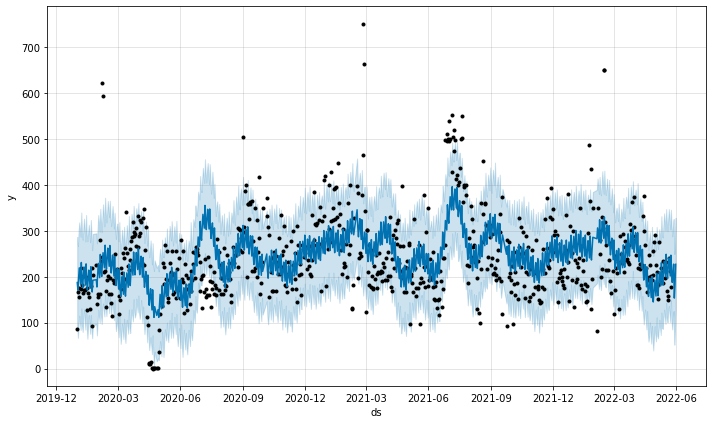

In [33]:
#result = prophet_analysis(14375, train_data)
result = prophet_analysis(1712010310, train_data)
result

In [21]:
result.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
732,2022-05-27,234.022358,107.900402,308.611979,234.022358,234.022358,-23.857114,-23.857114,-23.857114,7.016981,7.016981,7.016981,-30.874095,-30.874095,-30.874095,0.0,0.0,0.0,210.165244
733,2022-05-28,233.943282,130.933675,328.939886,233.943282,233.943282,-6.232875,-6.232875,-6.232875,27.527732,27.527732,27.527732,-33.760608,-33.760608,-33.760608,0.0,0.0,0.0,227.710406
734,2022-05-29,233.864205,51.450539,246.682803,233.864205,233.864205,-80.213649,-80.213649,-80.213649,-43.380497,-43.380497,-43.380497,-36.833152,-36.833152,-36.833152,0.0,0.0,0.0,153.650556
735,2022-05-30,233.785128,81.411718,276.857214,233.785128,233.785128,-50.371459,-50.371459,-50.371459,-10.348658,-10.348658,-10.348658,-40.022801,-40.022801,-40.022801,0.0,0.0,0.0,183.413669
736,2022-05-31,233.706052,124.559162,325.299736,233.706052,233.706052,-6.406196,-6.406196,-6.406196,36.850011,36.850011,36.850011,-43.256207,-43.256207,-43.256207,0.0,0.0,0.0,227.299856


In [24]:
#test_data[test_data['GOODS_NO']==14375]
test_data[test_data['GOODS_NO']==1712010310]

,ds,GOODS_NO,y
10817,2022-05-25,1712010310,126
10837,2022-05-26,1712010310,140
10857,2022-05-27,1712010310,121
10877,2022-05-28,1712010310,112
10897,2022-05-30,1712010310,98
10917,2022-05-31,1712010310,173


In [34]:
from prophet.diagnostics import cross_validation

train_data = train_data[train_data['GOODS_NO']==1712010310]
df = train_data.drop('GOODS_NO', axis=1)
m = Prophet(changepoint_range=0.9)
m.fit(train_data)

df_cv = cross_validation(m, horizon=7)
df_cv

16:41:02 - cmdstanpy - INFO - Chain [1] start processing
16:41:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/425 [00:00<?, ?it/s]

16:41:03 - cmdstanpy - INFO - Chain [1] start processing
16:41:03 - cmdstanpy - INFO - Chain [1] done processing
16:41:05 - cmdstanpy - INFO - Chain [1] start processing
16:41:05 - cmdstanpy - INFO - Chain [1] done processing
16:41:06 - cmdstanpy - INFO - Chain [1] start processing
16:41:06 - cmdstanpy - INFO - Chain [1] done processing
16:41:07 - cmdstanpy - INFO - Chain [1] start processing
16:41:07 - cmdstanpy - INFO - Chain [1] done processing
16:41:09 - cmdstanpy - INFO - Chain [1] start processing
16:41:09 - cmdstanpy - INFO - Chain [1] done processing
16:41:10 - cmdstanpy - INFO - Chain [1] start processing
16:41:10 - cmdstanpy - INFO - Chain [1] done processing
16:41:11 - cmdstanpy - INFO - Chain [1] start processing
16:41:11 - cmdstanpy - INFO - Chain [1] done processing
16:41:13 - cmdstanpy - INFO - Chain [1] start processing
16:41:13 - cmdstanpy - INFO - Chain [1] done processing
16:41:14 - cmdstanpy - INFO - Chain [1] start processing
16:41:14 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-01,347.192860,279.543875,415.800346,179,2020-12-31 23:59:59.999999993
1,2021-01-02,315.770898,251.633533,386.227078,284,2021-01-01 23:59:59.999999993
2,2021-01-04,262.410816,192.375573,328.384700,260,2021-01-03 23:59:59.999999993
3,2021-01-05,321.684619,255.011082,390.784062,401,2021-01-04 23:59:59.999999993
4,2021-01-06,298.563858,232.958325,369.679461,305,2021-01-05 23:59:59.999999993
...,...,...,...,...,...,...
420,2022-05-19,202.937595,91.062161,298.593005,149,2022-05-18 23:59:59.999999993
421,2022-05-20,226.489548,124.740659,323.855513,158,2022-05-19 23:59:59.999999993
422,2022-05-21,243.345287,147.198268,337.152949,241,2022-05-20 23:59:59.999999993
423,2022-05-23,203.294859,101.009741,304.893991,213,2022-05-22 23:59:59.999999993


In [35]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 00:00:00.000000007,9561.420629,97.782517,75.485065,0.328217,0.255274,0.289134,0.691765
